In [1]:
from contextlib import suppress

import numpy as np
import pandas as pd

# For pretty writing
from IPython.display import display, Markdown
from sklearn.cluster import KMeans

# Analyse exploratoire de données (Exploratory Data Analysis)


## Partie 0 - Outils

In [2]:
from pathlib import Path

from requests import get, Response
from hashlib import sha256
from tqdm.notebook import tqdm
from zipfile import ZipFile
from IPython.display import display, Markdown
import pandas as pd

_cache_folder = Path('~/.cache/gn_p7').expanduser()
_cache_folder.mkdir(parents=True, exist_ok=True)

_ds_url = 'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip'


def download(url: str) -> Path:
    url_id: str = sha256(url.encode('utf-8')).hexdigest()
    local_path: Path = _cache_folder / url_id
    local_path.parent.mkdir(parents=True, exist_ok=True)
    if not local_path.exists():
        tmp_path: Path = _cache_folder / (url_id + '.tmp')
        res: Response = get(url, stream=True)
        with tmp_path.open('wb') as f, tqdm(
                total=int(res.headers.get('content-length')),
                desc=f'Downloading {url}',
                unit_scale=True) as q:
            for chunk in res.iter_content(chunk_size=8192):
                q.update(len(chunk))
                f.write(chunk)
        tmp_path.replace(local_path)
    return local_path


def download_zip_archive(url: str) -> Path:
    """Download a zip archive, extract it then return the folder containing its content"""
    archive_path: Path = download(url)
    archive_folder: Path = Path(archive_path.as_posix() + '.dir')

    if not archive_folder.exists():
        print(f'Extracting archive {url}...', flush=True)
        archive_temp: Path = Path(archive_path.as_posix() + '.tmp')
        archive_temp.mkdir(parents=True, exist_ok=True)
        archive: ZipFile = ZipFile(archive_path)
        archive.extractall(path=archive_temp)
        archive_temp.replace(archive_folder)
        print(f'Extracting archive {url}...done', flush=True)

    return archive_folder


def get_dataset(name: str) -> pd.DataFrame:
    folder = download_zip_archive(_ds_url)
    if not name.endswith('.csv'):
        name = f'{name}.csv'
    try:
        return pd.read_csv(folder / name)
    except FileNotFoundError:
        display(Markdown(f'# ERROR: Dataset {name!r} not found, available datasets are:\n' + '\n'.join(
            f'- {p.name}' for p in sorted(folder.iterdir(), key=(lambda x: x.name.lower())))))
        raise KeyError(name) from None


In [3]:
# Scoring related
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


def confusion(
        y_truth: pd.Series,
        y_prediction: pd.Series,
        model_name: str,
) -> dict:
    assert len(y_truth) == len(y_prediction), "Input Series must have the same length."
    classes = sorted(set(y_truth) | set(y_prediction))
    matrix = confusion_matrix(y_truth, y_prediction, labels=classes)
    sns.heatmap(matrix / len(y_truth), annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix for {model_name!r}', fontsize=16)
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()
    return {
        # TODO: More metrics
        'accuracy': accuracy_score(y_truth, y_prediction),
        'precision': precision_score(y_truth, y_prediction, zero_division=0),
        'recall': recall_score(y_truth, y_prediction, zero_division=0),
        'f1_score': f1_score(y_truth, y_prediction, zero_division=0)
    }

## Partie 1 - Applications
Notre dataset contiens plusieurs fichiers.
Nous feront comme le notebook exemple, en commençant initialement avec application_{train,test}, puis en rajoutant des données pour améliorer la performance du modèle.

### Partie 1.1 - Données brutes

Il serai peut-être nécéssaire de prétraiter les données, cependant je vais tenter de créer un modèle initial sur les données brutes pour servir de référence

### 1.1.1 - k-Means

k-Means est linéaire, et non supervisé, il aura probablement un score assez faible

# WARNING: k-Means distinguish between two classes, but might switch classes

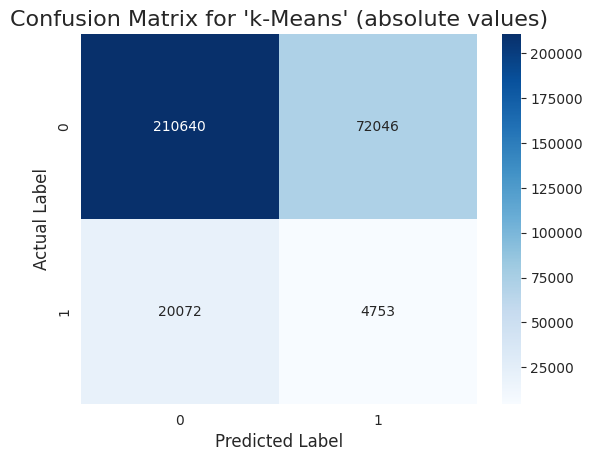

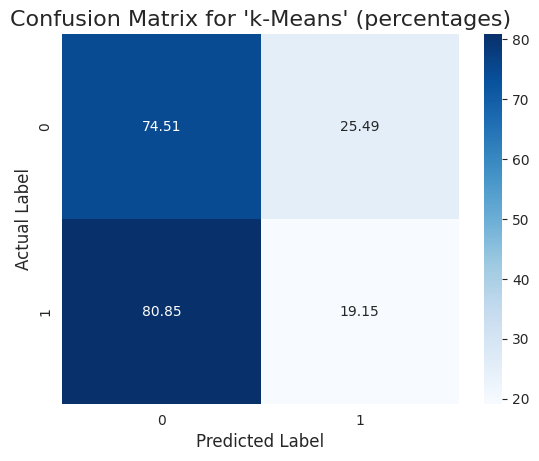

{'accuracy': 0.7004399842607256,
 'precision': 0.061888826677430696,
 'recall': 0.19146022155085599,
 'f1_score': 0.09354089585137369}

In [4]:
# Scoring related
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


def heat_map(matrix: np.ndarray, classes: list[str], title: str, y_label: str, x_label: str, fmt: str) -> None:
    sns.heatmap(matrix, annot=True, fmt=fmt, xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.title(title, fontsize=16)
    plt.ylabel(y_label, fontsize=12)
    plt.xlabel(x_label, fontsize=12)
    plt.show()


def confusion(
        y_truth: pd.Series,
        y_prediction: pd.Series,
        model_name: str,
) -> dict:
    assert len(y_truth) == len(y_prediction), "Input Series must have the same length."
    classes = sorted(set(y_truth) | set(y_prediction))
    heat_map(
        (matrix := confusion_matrix(y_truth, y_prediction, labels=classes)),
        classes, f'Confusion Matrix for {model_name!r} (absolute values)', 'Actual Label', 'Predicted Label', 'd')

    # 'matrix' est la matrice de confusion non normalisée
    # On divise chaque valeur par la somme de sa ligne
    # np.newaxis est crucial pour que la division se fasse correctement
    heat_map(
        (100 * (matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis])),
        classes, f'Confusion Matrix for {model_name!r} (percentages)', 'Actual Label', 'Predicted Label', '.02f')

    return {
        # TODO: More metrics
        'accuracy': accuracy_score(y_truth, y_prediction),
        'precision': precision_score(y_truth, y_prediction, zero_division=0),
        'recall': recall_score(y_truth, y_prediction, zero_division=0),
        'f1_score': f1_score(y_truth, y_prediction, zero_division=0)
    }


def k_means():
    display(Markdown('# WARNING: k-Means distinguish between two classes, but might switch classes'))
    X = get_dataset('application_train.csv')
    y_true = X.pop('TARGET')
    for column in list(X.columns):
        try:
            X[column] = X[column].astype(float).fillna(0)
        except ValueError:
            X.pop(column)
    model = KMeans(len(y_true.unique()))
    y_pred = model.fit(X).predict(X)
    return confusion(y_true, y_pred, 'k-Means')


k_means()

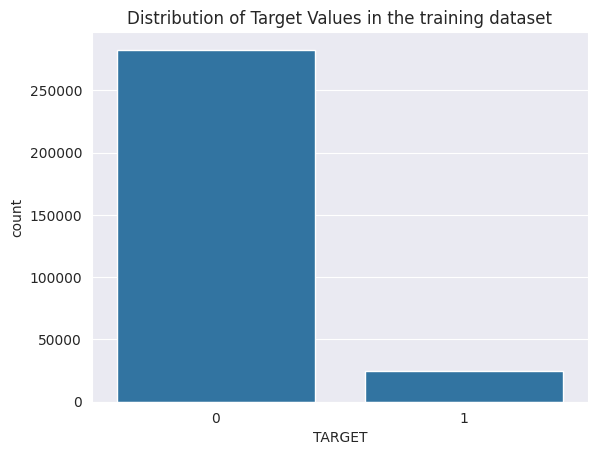

<b>Nous pouvons voir ici un clair déséquilibre des classes, en effet, seuls 8.07% des clients ont difficultés de paiement</b><br>

In [7]:
# Similar to plt.hist, but automatically labels the axes
plt.show(sns.countplot(data=(tmp := get_dataset('application_train.csv')), x='TARGET').set_title(
    'Distribution of Target Values in the training dataset').figure)

display(Markdown(
    '<b>Nous pouvons voir ici un clair déséquilibre des classes, en effet, '
    f'seuls {100 * sum(tmp.TARGET) / len(tmp.TARGET):.2f}% des clients ont difficultés de paiement</b><br>'
))

### 1.1.2 Start Here: A Gentle Introduction

Je vais ici tester les méthodes proposées par le notebook de référence.
Le but étant de m'acclimater aux outils proposés.

#### Importation des librairies utilisées plus bas

In [8]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings
import warnings

warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#### Chargement des deux datasets

In [9]:
(app_train := get_dataset('application_train'))

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
(app_test := get_dataset('application_test'))

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


#### Traitement des valeurs manquantes (déséquilibre TARGET déjà vu plus tôt)

In [18]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
                                                              "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns


# Missing values statistics
(missing_values := missing_values_table(app_train))

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


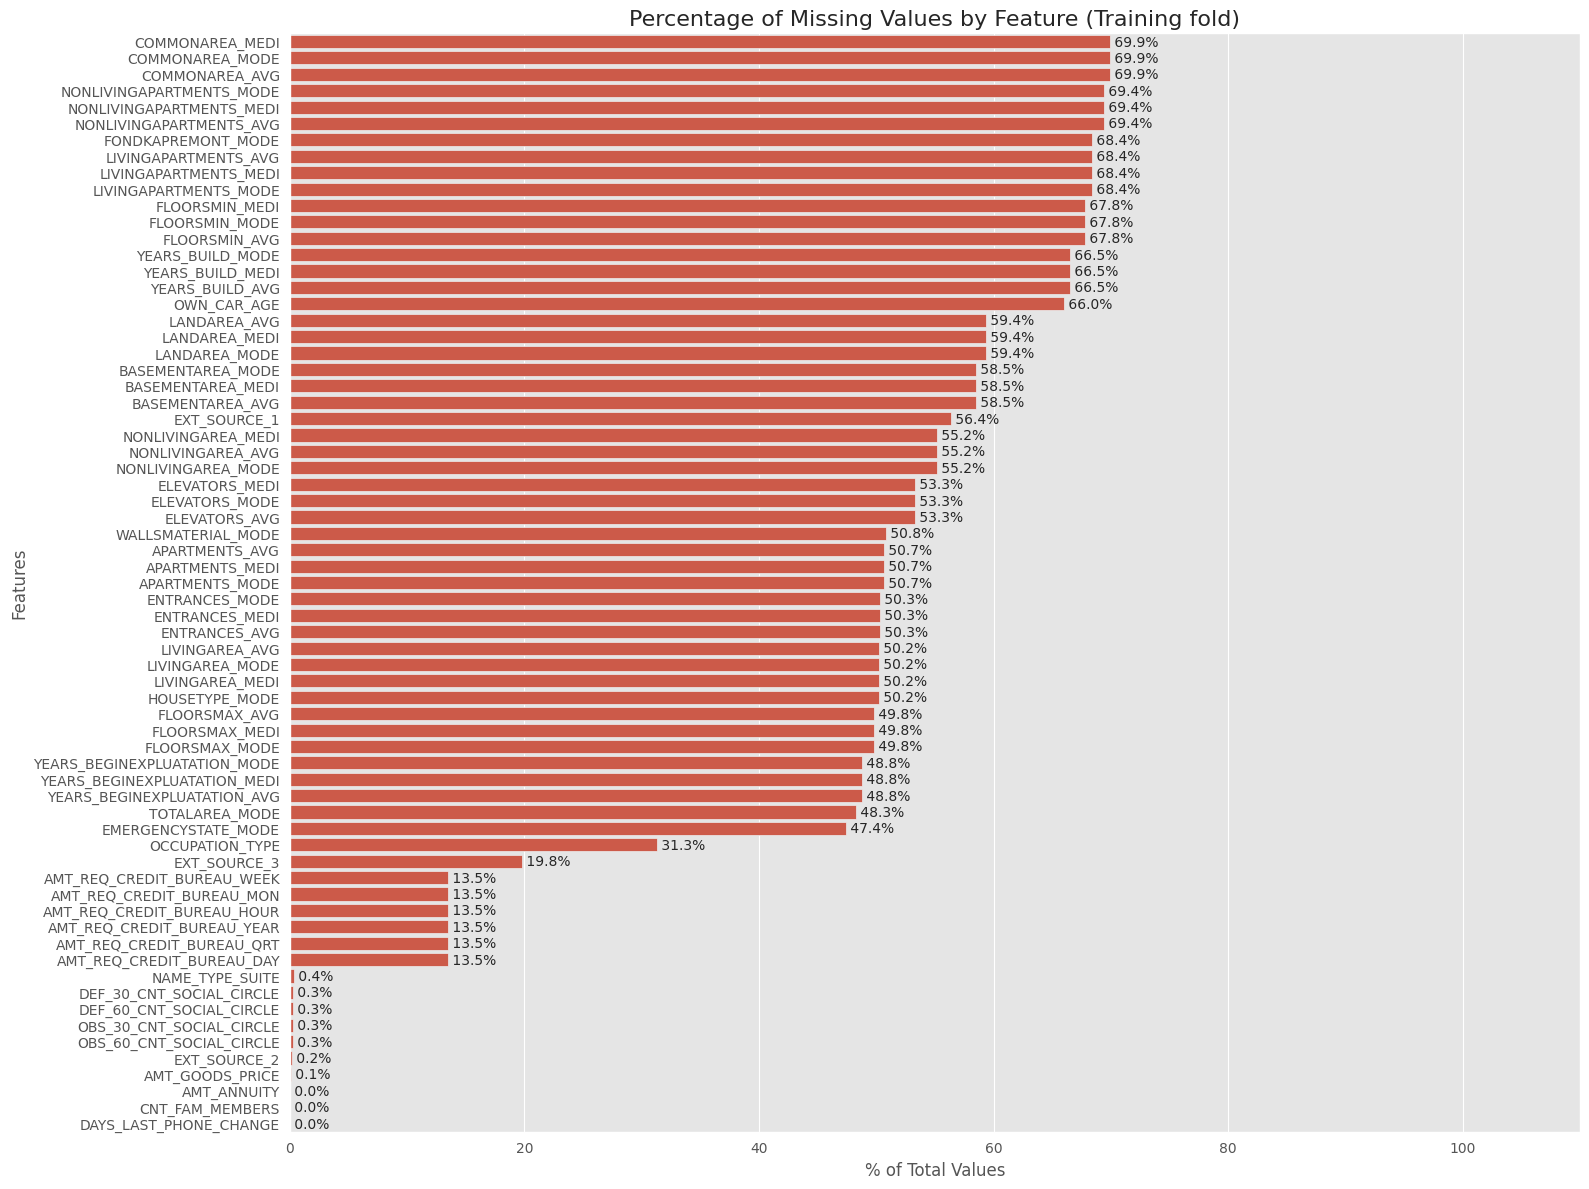

Your selected dataframe has 121 columns.
There are 64 columns that have missing values.


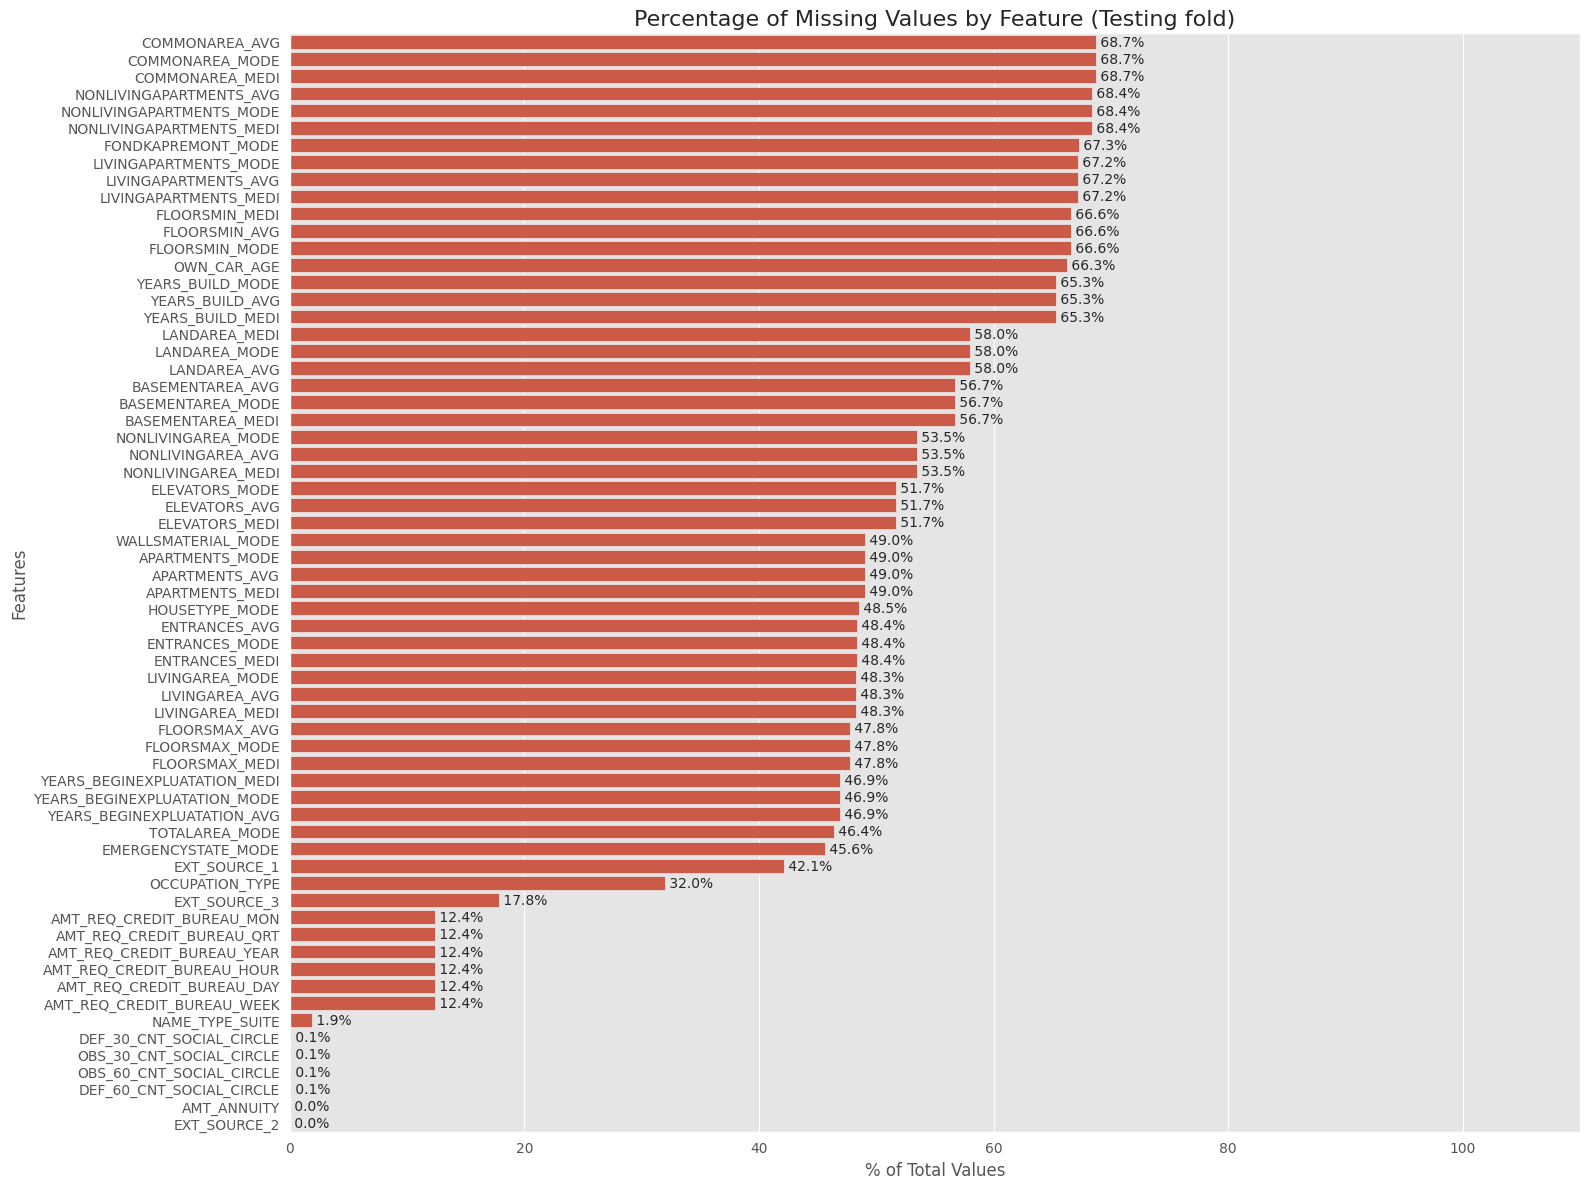

In [27]:
for fold in ('train', 'test'):
    missing_test_values = missing_values_table(get_dataset('application_' + fold + '.csv'))

    # TODO: Set the plot style for dark mode when exporting to png
    plt.figure(figsize=(16, 12))  # There are a lot of columns
    sns.barplot(x=missing_test_values['% of Total Values'], y=missing_test_values.index)
    plt.title(f'Percentage of Missing Values by Feature ({fold.title()}ing fold)', fontsize=16)
    plt.xlabel('% of Total Values', fontsize=12)
    plt.ylabel('Features', fontsize=12)

    # Add percentage text on the bars
    for index, value in enumerate(missing_test_values['% of Total Values']):
        plt.text(value, index, f' {value}%', va='center')

    plt.xlim(0, 110)  # Set x-limit to give space for text
    plt.tight_layout()
    plt.savefig('test.png')
    plt.show()

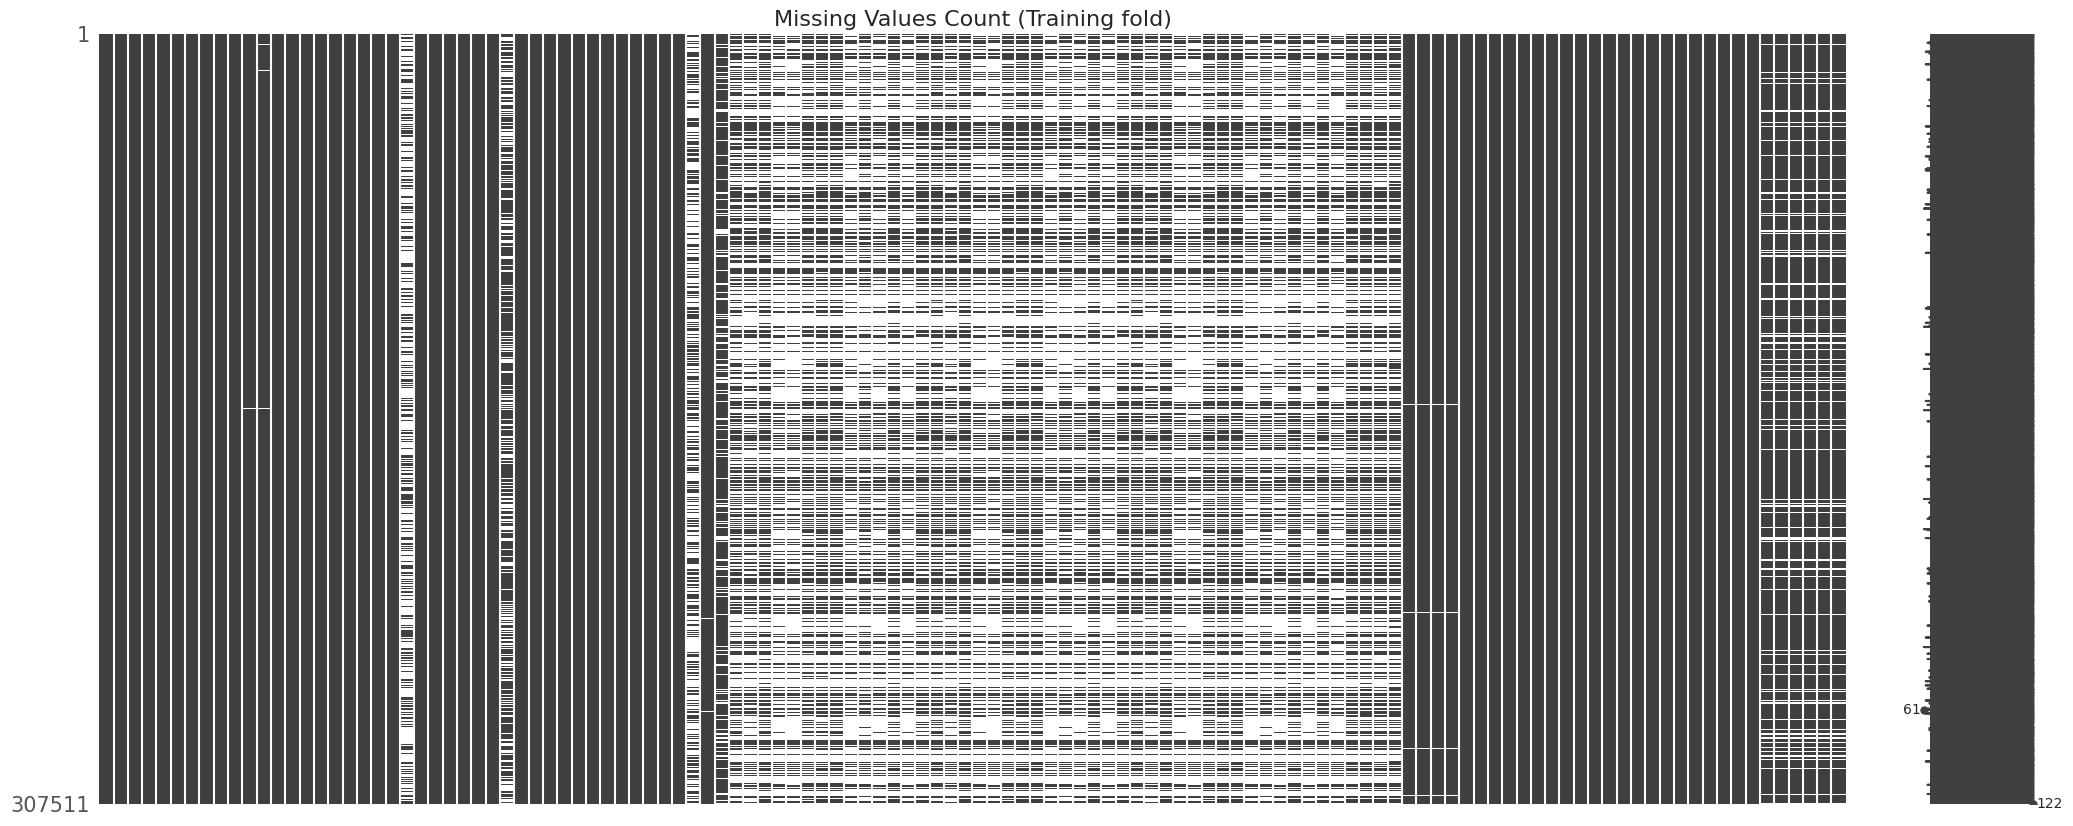

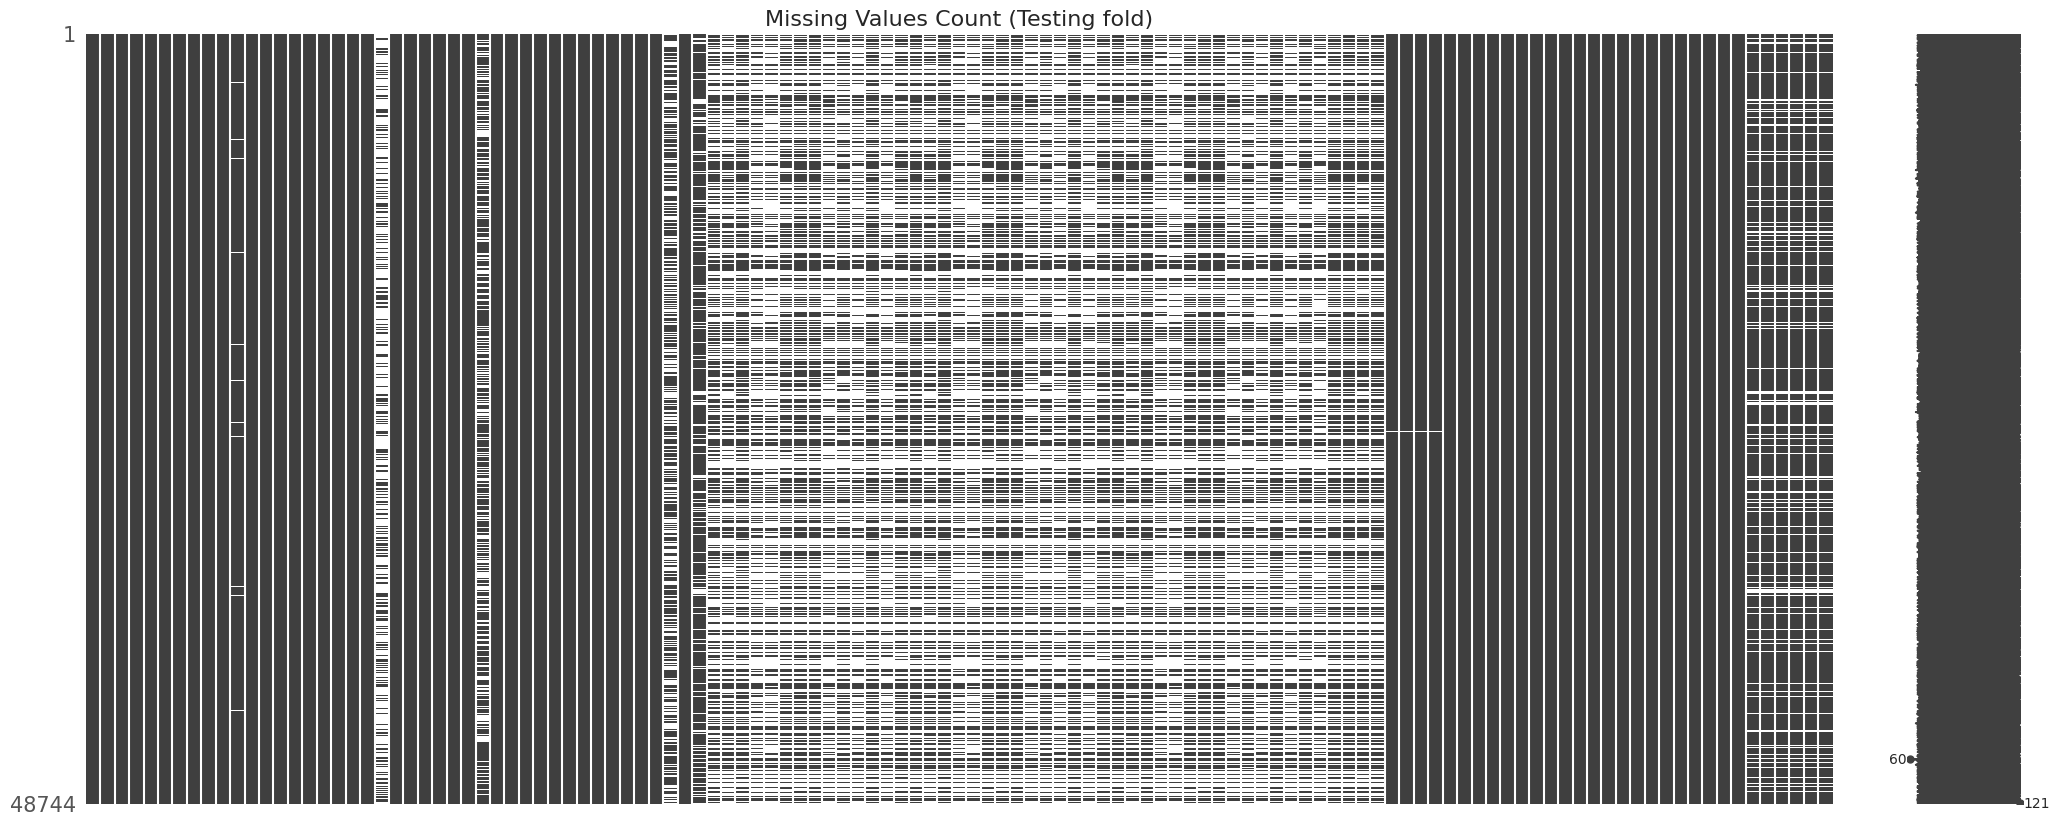

In [30]:
import missingno as msno

for fold in ('train', 'test'):
    msno.matrix(get_dataset('application_' + fold + '.csv'), fontsize=12)
    plt.title(f'Missing Values Count ({fold.title()}ing fold)', fontsize=16)
    plt.show()

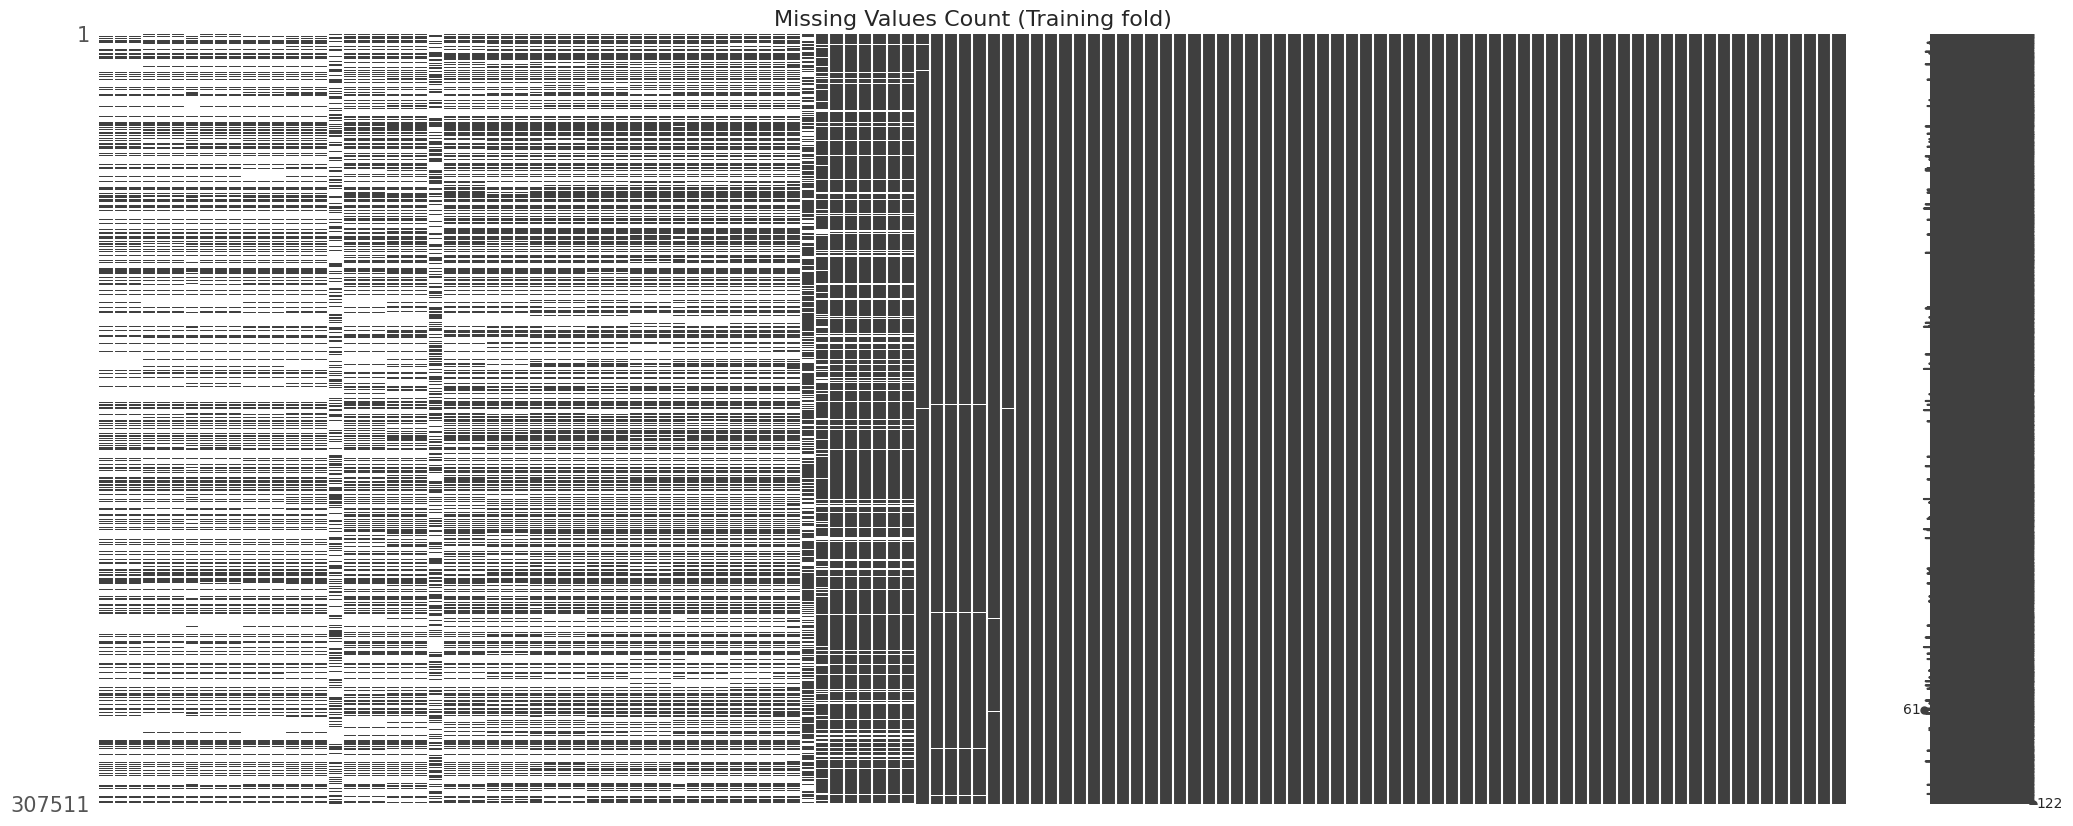

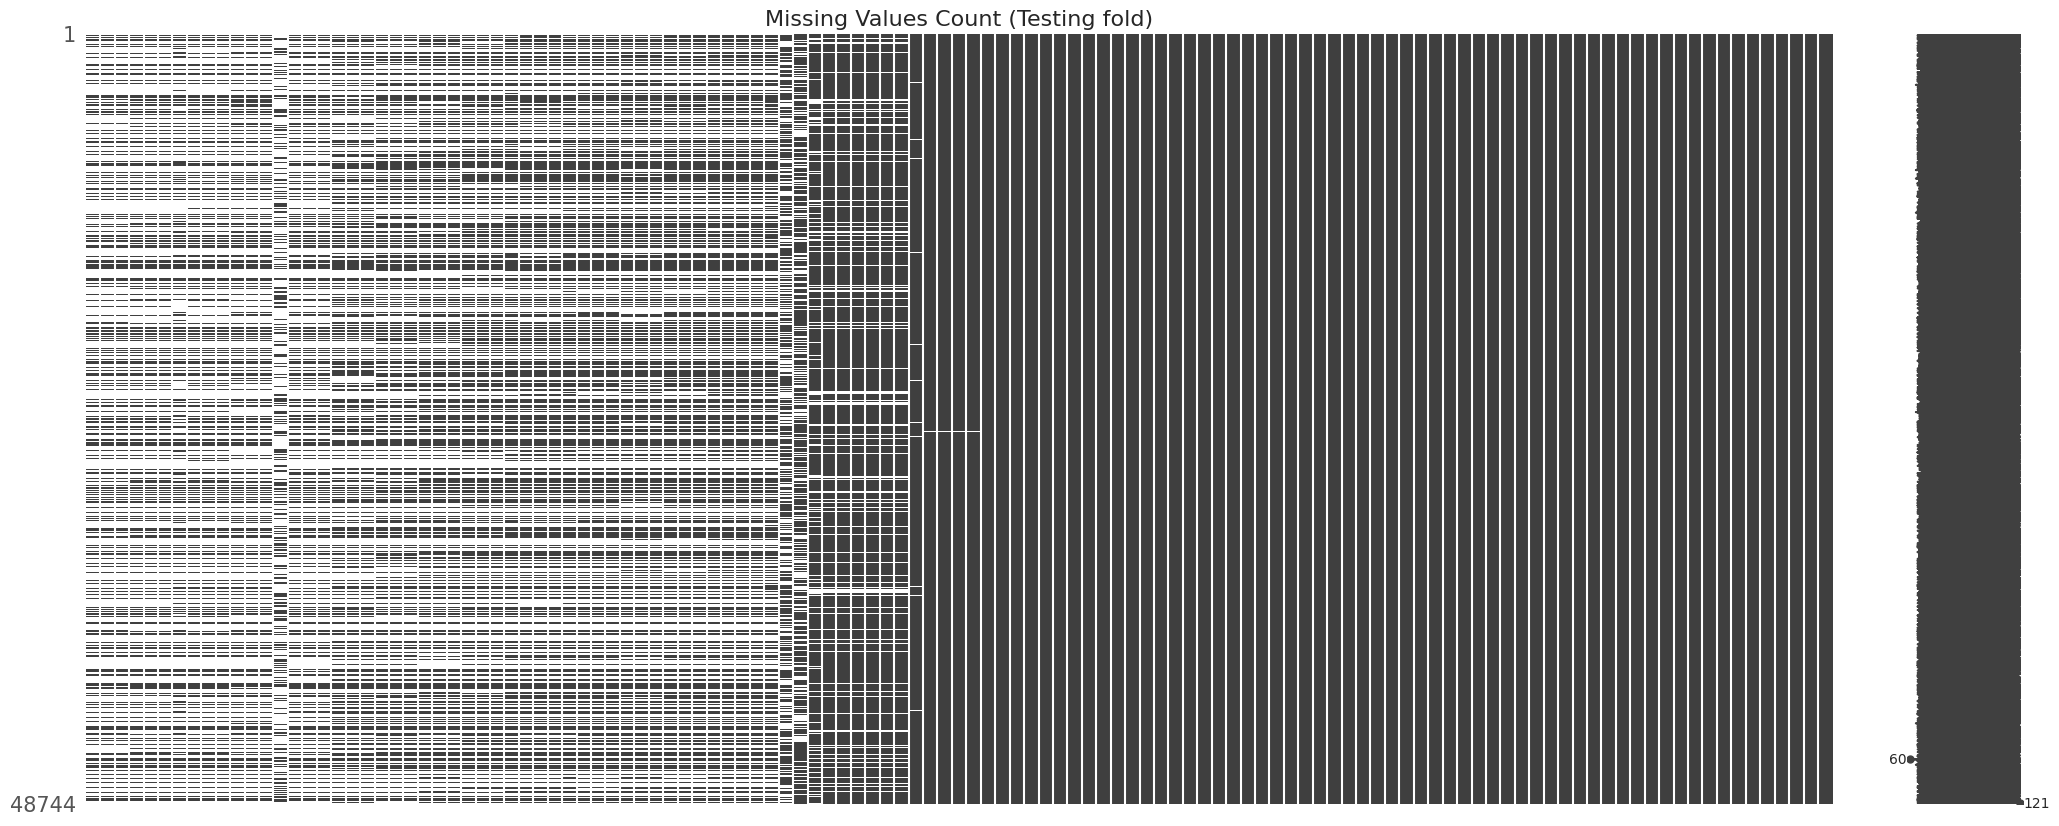

In [40]:
import missingno as msno

for fold in ('train', 'test'):
    df = get_dataset('application_' + fold + '.csv')
    msno.matrix(df[list(sorted(df.columns, key=(lambda col: int(df[col].notna().sum()))))], fontsize=12)
    plt.title(f'Missing Values Count ({fold.title()}ing fold)', fontsize=16)
    plt.show()

On peut voir ce qui a été montré précédemment, la moitié des colonnes ne possèdent aucunes valeurs manquantes, et le reste va grossièrement de 40 à 60 pourcent de valeurs manquantes

In [17]:
train_test_diff_col, = set(app_train) - set(app_test)
display(Markdown(f'La colonne **{train_test_diff_col!r}** est la seule à manquer du dataset de test'))

La colonne **'TARGET'** est la seule à manquer du dataset de test

In [44]:
assert not app_train.TARGET.isna().sum()
display(Markdown('Il ne manque aucune target'))


Il ne manque aucune target